In [1]:
# 시뮬레이션 라이브러리 불러오기
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import pickle
import math

import sys
from meep.materials import SiN

In [2]:
# 물질 설정 및 Refractive Index 설정
mp.verbosity(1)
um_scale = 1

Air = mp.Medium(index=1.0)

In [3]:
resolution = 600 # 해상도
design_region_width = 0.01 # 디자인 영역 x
design_region_width_y = 0.01 # 디자인 영역 y
design_region_height = 2 # 디자인 영역 높이 z
pml_size = 1.0 # PML 영역 크기

In [4]:
# 시뮬레이션 공간 설정
Sx = design_region_width
Sy = design_region_width_y
Sz = 2 * pml_size + design_region_height + 1 + 5
cell_size = mp.Vector3(Sx, Sy, Sz)

In [5]:
wavelengths = np.array([0.41*um_scale, 0.43*um_scale, 0.45*um_scale, 0.51*um_scale, 0.54*um_scale, 0.57*um_scale, 0.64*um_scale, 0.68*um_scale, 0.72*um_scale])
# wavelengths = np.array([1.5])
frequencies = 1/wavelengths
nf = len(frequencies) # number of frequencies

In [6]:
minimum_length = 0.05  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
design_region_resolution = int(resolution)

In [7]:
pml_layers = [mp.PML(thickness = pml_size, direction = mp.Z)]

In [8]:
width = 0.1
fcen_red0 = frequencies[6]
fwidth_red0 = width * fcen_red0
fcen_red1 = frequencies[7]
fwidth_red1 = width * fcen_red1
fcen_red2 = frequencies[8]
fwidth_red2 = width * fcen_red2

fcen_green0 = frequencies[3]
fwidth_green0 = width * fcen_green0
fcen_green1 = frequencies[4]
fwidth_green1 = width * fcen_green1
fcen_green2 = frequencies[5]
fwidth_green2 = width * fcen_green2

fcen_blue0 = frequencies[0]
fwidth_blue0 = width * fcen_blue0
fcen_blue1 = frequencies[1]
fwidth_blue1 = width * fcen_blue1
fcen_blue2 = frequencies[2]
fwidth_blue2 = width * fcen_blue2

In [9]:
source_center = [0, 0, Sz / 2 - pml_size] # Source 위치
source_size = mp.Vector3(Sx, Sy, 0)

src_0 = mp.GaussianSource(frequency=fcen_red2, fwidth=fwidth_red2, is_integrated=True)
src_1 = mp.GaussianSource(frequency=fcen_red1, fwidth=fwidth_red1, is_integrated=True)
src_2 = mp.GaussianSource(frequency=fcen_red0, fwidth=fwidth_red0, is_integrated=True)
src_3 = mp.GaussianSource(frequency=fcen_green2, fwidth=fwidth_green2, is_integrated=True)
src_4 = mp.GaussianSource(frequency=fcen_green1, fwidth=fwidth_green1, is_integrated=True)
src_5 = mp.GaussianSource(frequency=fcen_green0, fwidth=fwidth_green0, is_integrated=True)
src_6 = mp.GaussianSource(frequency=fcen_blue2, fwidth=fwidth_blue2, is_integrated=True)
src_7 = mp.GaussianSource(frequency=fcen_blue1, fwidth=fwidth_blue1, is_integrated=True)
src_8 = mp.GaussianSource(frequency=fcen_blue0, fwidth=fwidth_blue0, is_integrated=True)

source = [mp.Source(src_0, component=mp.Ey, size=source_size, center=source_center),
          mp.Source(src_1, component=mp.Ey, size=source_size, center=source_center),
          mp.Source(src_2, component=mp.Ey, size=source_size, center=source_center),
          mp.Source(src_3, component=mp.Ey, size=source_size, center=source_center),
          mp.Source(src_4, component=mp.Ey, size=source_size, center=source_center),
          mp.Source(src_5, component=mp.Ey, size=source_size, center=source_center),
          mp.Source(src_6, component=mp.Ey, size=source_size, center=source_center),
          mp.Source(src_7, component=mp.Ey, size=source_size, center=source_center),
          mp.Source(src_8, component=mp.Ey, size=source_size, center=source_center)]


In [10]:
Nx = int(round(design_region_resolution * design_region_width)) + 1
Ny = int(round(design_region_resolution * design_region_width_y)) + 1
Nz = int(round(design_region_resolution * design_region_height)) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny, Nz), Air, SiN, grid_type="U_MEAN")



In [11]:
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, 0, Sz / 2 - pml_size - 2),
        size=mp.Vector3(design_region_width, design_region_width_y, design_region_height),
    ),
)


In [12]:
geometry = [
    mp.Block(
        center=design_region.center, size=mp.Vector3(design_region_width, design_region_width_y, 0.3 * um_scale), material=SiN
    )
]

In [13]:
sim = mp.Simulation(
    cell_size=cell_size, 
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air, # 빈공간
    resolution=resolution,
    extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)

# 모니터 위치와 크기 설정 (focal point)
monitor_position_0, monitor_size_0 = mp.Vector3(-Sx/2 + 1, Sy/2  - 1, -Sz/2 + pml_size + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_1, monitor_size_1 = mp.Vector3(-Sx/2 + 1, -Sy/2 + 1, -Sz/2 + pml_size + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_2, monitor_size_2 = mp.Vector3(Sx/2 - 1, -Sy/2 + 1, -Sz/2 + pml_size + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_3, monitor_size_3 = mp.Vector3(Sx/2 - 1, Sy/2  -  1, -Sz/2 + pml_size + 0.5/resolution), mp.Vector3(0.01,0.01,0) 

# FourierFields를 통해 monitor_position에서 monitor_size만큼의 영역에 대한 Fourier transform을 구함
FourierFields_0 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ey,yee_grid=True)
FourierFields_1 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ey,yee_grid=True)
FourierFields_2 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ey,yee_grid=True)
FourierFields_3 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ey,yee_grid=True)
FourierFields_4 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ey,yee_grid=True)
FourierFields_5 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ey,yee_grid=True)
FourierFields_6 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ey,yee_grid=True)
FourierFields_7 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ey,yee_grid=True)
FourierFields_8 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ey,yee_grid=True)
FourierFields_9 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ey,yee_grid=True)
FourierFields_10 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ey,yee_grid=True)
FourierFields_11 = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ey,yee_grid=True)
ob_list = [FourierFields_0, FourierFields_1, FourierFields_2,FourierFields_3, FourierFields_4, FourierFields_5 ,FourierFields_6, FourierFields_7, FourierFields_8,FourierFields_9, FourierFields_10, FourierFields_11]

# In[16]:


# J : Objective function
# FourierFields가 측정한 필드, 모니터의 중심에서 Ez 구성요소의 절댓값을 제곱한 값을 취한 후 평균을 계산하여 평균 강도를 계산
def J_0(fields_0, fields_1, fields_2,fields_3, fields_4, fields_5,fields_6, fields_7, fields_8,fields_9, fields_10, fields_11):
    return npa.mean(npa.abs(fields_0[6,:]) ** 2) + npa.mean(npa.abs(fields_1[7,:]) ** 2) + npa.mean(npa.abs(fields_2[8,:]) ** 2) + npa.mean(npa.abs(fields_3[3,:]) ** 2) + npa.mean(npa.abs(fields_4[4,:]) ** 2) + npa.mean(npa.abs(fields_5[5,:]) ** 2) + npa.mean(npa.abs(fields_6[0,:]) ** 2) + npa.mean(npa.abs(fields_7[1,:]) ** 2) + npa.mean(npa.abs(fields_8[2,:]) ** 2) + npa.mean(npa.abs(fields_9[3,:]) ** 2) + npa.mean(npa.abs(fields_10[4,:]) ** 2) + npa.mean(npa.abs(fields_11[5,:]) ** 2)

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J_0],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    decay_by=1e-5
)


     block, center = (0,0,2)
          size (0.01,0.01,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.32,2.32,2.32)


/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/visualization.py:271: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


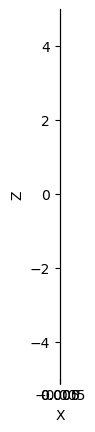

In [14]:
opt.plot2D(False, output_plane = mp.Volume(size = (np.inf, 0, np.inf), center = (0,0,0)))

In [15]:
opt.sim.reset_meep()
#simulation 1 : geometry가 없는 구조
geometry_1 = [
    mp.Block(
        center=mp.Vector3(0, 0, 0), size=mp.Vector3(Sx, Sy, 0), material=Air
    )
]

     block, center = (0,0,0)
          size (0.01,0.01,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


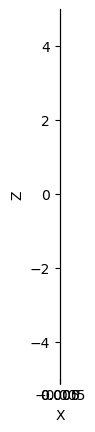

In [16]:

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy, Sz),
    boundary_layers=pml_layers,
    geometry=geometry_1,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)
fcen = (1/(0.40 * um_scale) + 1/(0.70 * um_scale))/2
df = 1 /(0.40 * um_scale) - 1/(0.70 * um_scale)
nfreq = 100

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)
# print((frequencies[2]+frequencies[0])/2)
source = [mp.Source(src, component=mp.Ey, size=source_size, center=source_center)]
opt.sim.change_sources(source)
opt.plot2D(False, output_plane = mp.Volume(size = (np.inf, 0, np.inf), center = (0,0,0)))

In [17]:
#reflection moniter 설정

refl_fr = mp.FluxRegion(
    center=mp.Vector3(0, 0, Sz/2 - pml_size - 0.3), size=mp.Vector3(Sx, Sy, 0)
) 
refl = opt.sim.add_flux(fcen, df, nfreq, refl_fr)

#transmission moiniter 설정

tran_t = mp.FluxRegion(
    center=mp.Vector3(0, 0, -Sz/2 + pml_size + 0.5), size=mp.Vector3(Sx, Sy, 0)
)
tran_total = opt.sim.add_flux(fcen, df, nfreq, tran_t)


#pt는 transmitted flux region과 동일

pt = mp.Vector3(0, 0, -Sz/2 + pml_size + 0.5)


#source가 끝난 후에 50 동안 계속 실행하며 component는 Ey, pt 설계의 끝에서 |Ey|^2의 값이 최대 값으로부터 1/1000 만큼 감쇠할때까지
#추가적인 50 단위의 시간 실행 -> Fourier-transform 수렴예상

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ey,pt,1e-3))

#데이터 저장

straight_refl_data = opt.sim.get_flux_data(refl)
total_flux = mp.get_fluxes(tran_total)
flux_freqs = mp.get_flux_freqs(tran_total)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000293016 s
Working in 3D dimensions.
Computational cell is 0.01 x 0.01 x 10 with resolution 600
     block, center = (0,0,0)
          size (0.01,0.01,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.371364 s
lorentzian susceptibility: frequency=5.23857, gamma=0.321009
-----------
on time step 710 (time=0.591667), 0.00563495 s/step
on time step 1710 (time=1.425), 0.00400025 s/step
on time step 2726 (time=2.27167), 0.00393776 s/step
on time step 3717 (time=3.0975), 0.00403874 s/step
on time step 4773 (time=3.9775), 0.00379115 s/step
on time step 5777 (time=4.81417), 0.00398434 s/step
on time step 6759 (time=5.6325), 0.0040745 s/step
on time step 7702 (time=6.41833), 0.00424463 s/step
on time step 8747 (time=7.28917), 0.00383034 s/step
on time step 9823 (time=8.18583), 0.00371797 s/step
on time step 10902 (time=9.085), 0.00370725 s/step
fie

In [18]:
opt.sim.reset_meep()

#simulation 2 : geometry가 있는 구조

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy, Sz),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    extra_materials=[SiN],
    k_point = mp.Vector3(0,0,0)
)

fcen = (1/(0.40 * um_scale) + 1/(0.70 * um_scale))/2
df = 1 /(0.40 * um_scale) - 1/(0.70 * um_scale)

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)
# print((frequencies[2]+frequencies[0])/2)
source = [mp.Source(src, component=mp.Ey, size=source_size, center=source_center)]
opt.sim.change_sources(source)

In [19]:
# 반사된 flux 구하기

refl = opt.sim.add_flux(fcen, df, nfreq, refl_fr)

# 투과된 flux 구하기

tran_fr = mp.FluxRegion(
    center=mp.Vector3(0, 0, -Sz/2 + pml_size + 0.5), size=mp.Vector3(Sx, Sy, 0)
)
tran = opt.sim.add_flux(fcen, df, nfreq, tran_fr)

#반사된 필드와 입사되는 필드를 구분하기 위해서 The Fourier-transformed incident fields을
#the Fourier transforms of the scattered fields 에서 빼줍니다.

opt.sim.load_minus_flux_data(refl, straight_refl_data)

#각각 픽셀의 flux 구하기

# tran_r = mp.FluxRegion(
#     center=mp.Vector3(-Sx/2 + 1, Sy/2  - 1, -Sz/2 + pml_size + 0.5/resolution), size=mp.Vector3(2, 2, 0)
# )
# tran_g = mp.FluxRegion(
#     center=mp.Vector3(-Sx/2 + 1, -Sy/2 + 1, -Sz/2 + pml_size + 0.5/resolution), size=mp.Vector3(2, 2, 0)
# )
# tran_b = mp.FluxRegion(
#     center=mp.Vector3(Sx/2 - 1, -Sy/2 + 1, -Sz/2 + pml_size + 0.5/resolution), size=mp.Vector3(2, 2, 0)
# )
# tran_g0 = mp.FluxRegion(
#     center=mp.Vector3(Sx/2 - 1, Sy/2  -  1, -Sz/2 + pml_size + 0.5/resolution), size=mp.Vector3(2, 2, 0)
# )

# tran_red = opt.sim.add_flux(fcen, df, nfreq, tran_r)
# tran_green = opt.sim.add_flux(fcen, df, nfreq, tran_g)
# tran_blue = opt.sim.add_flux(fcen, df, nfreq, tran_b)
# tran_green0 = opt.sim.add_flux(fcen, df, nfreq, tran_g0)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000281096 s
Working in 3D dimensions.
Computational cell is 0.01 x 0.01 x 10 with resolution 600
     block, center = (0,0,2)
          size (0.01,0.01,0.3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.32,2.32,2.32)
time for set_epsilon = 0.370494 s
lorentzian susceptibility: frequency=5.23857, gamma=0.321009
-----------


In [20]:
pt = mp.Vector3(0, 0, -Sz/2 + pml_size + 0.5) #pt는 transmitted flux region과 동일

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ey,pt,1e-3))

#데이터 저장

bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

# red_flux = mp.get_fluxes(tran_red)
# green_flux = mp.get_fluxes(tran_green)
# blue_flux = mp.get_fluxes(tran_blue)
# green_flux0 = mp.get_fluxes(tran_green0)

on time step 416 (time=0.346667), 0.00961961 s/step
on time step 985 (time=0.820833), 0.00703783 s/step
on time step 1587 (time=1.3225), 0.00665085 s/step
on time step 2197 (time=1.83083), 0.00655837 s/step
on time step 2775 (time=2.3125), 0.00693086 s/step
on time step 3371 (time=2.80917), 0.00672124 s/step
on time step 3973 (time=3.31083), 0.00665629 s/step
on time step 4591 (time=3.82583), 0.00648028 s/step
on time step 5188 (time=4.32333), 0.00670652 s/step
on time step 5752 (time=4.79333), 0.00710473 s/step
on time step 6342 (time=5.285), 0.0067844 s/step
on time step 6917 (time=5.76417), 0.0069573 s/step
on time step 7514 (time=6.26167), 0.00670493 s/step
on time step 8086 (time=6.73833), 0.00700302 s/step
on time step 8678 (time=7.23167), 0.00675968 s/step
on time step 9267 (time=7.7225), 0.0067919 s/step
on time step 9892 (time=8.24333), 0.00640562 s/step
on time step 10491 (time=8.7425), 0.00668386 s/step
on time step 11114 (time=9.26167), 0.00642641 s/step
on time step 11724 

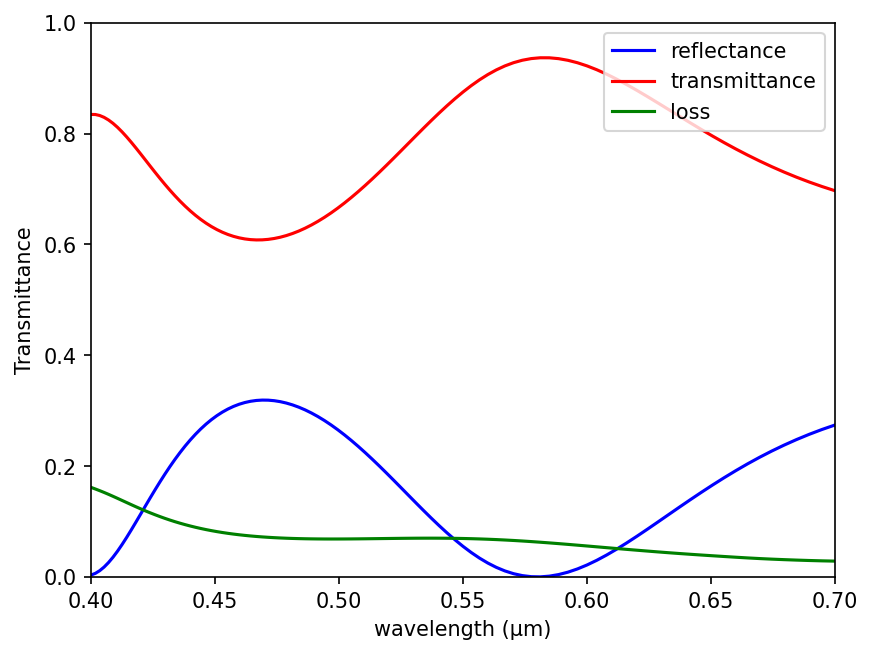

In [21]:
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Rs = np.append(Rs, -bend_refl_flux[i] / total_flux[i])
    Ts = np.append(Ts, bend_tran_flux[i] / total_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rs, "b", label="reflectance")
    plt.plot(wl, Ts, "r", label="transmittance")
    plt.plot(wl, 1 - Rs - Ts, "g", label="loss")
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Transmittance")
    plt.legend(loc="upper right")
    #plt.show()
    #plt.savefig("Transmission2.png")

In [22]:
np.savetxt("Reflection_my_code.txt",Rs)
np.savetxt("Transmission_my_code.txt",Ts)